In [1]:
from __future__ import division, unicode_literals, print_function  
import numpy as np
import matplotlib.pyplot as plt
#import pims  # image reading routines
import os
import math

import pandas as pd
#from pandas import DataFrame, Series  

import trackpy as tp
from scipy import ndimage  # for shifting images
#from pims import pipeline
#from pims import Frame
from scipy.interpolate import griddata  # for resampling
import matplotlib.patches as mpatches   # circles
from scipy.signal import savgol_filter
#from skimage.transform import rotate

from scipy import odr
import scipy.stats as stats

#%load_ext autoreload
#%autoreload 2

#from track_lib import  *

from scipy.optimize import curve_fit
# Function to calculate the exponential with constants a and b
def exponential(x, a, b):
    return a*np.exp(b*x)

def power(x, a, b):
    return a*(x**b)

xs = np.array([4.0,5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0])
R=5.5

In [2]:
xerr = 0.3   #cm
yerr = 0.02  #cm half a grain radius
#verr = (((fps**2)*(2*yerr**2))**0.5)/100 #via error adding rules, because error in time is tiny in comparison to error in position. Then divide by 100 to go from cm/s to m/s
verr = yerr/100 #convert to meters, the more "correct" version doesn't really work

Radial position curves

In [3]:
#load radial displacements
a1 = pd.read_csv("PTV1a.csv")
s1 = pd.read_csv("PTV1s.csv")
a2 = pd.read_csv("PTV2a.csv")
s2 = pd.read_csv("PTV2s.csv")
a3 = pd.read_csv("PTV3a.csv")
s3 = pd.read_csv("PTV3s.csv")

In [4]:
total = np.zeros((6,3,100)) #run number,init_pos or final_pos or peak_pos, particle number

In [5]:
a2.loc[30,"init_pos"] #[index,column]

7.315752835295958

In [6]:
#load initial position from above videos
total[0,0,:a1.loc[:,"init_pos"].size]=a1.loc[:,"init_pos"]
total[1,0,:a2.loc[:,"init_pos"].size]=a2.loc[:,"init_pos"]
total[2,0,:a3.loc[:,"init_pos"].size]=a3.loc[:,"init_pos"]
#load initial position from side videos
total[3,0,:s1.loc[:,"init_pos"].size]=s1.loc[:,"init_pos"]
total[4,0,:s2.loc[:,"init_pos"].size]=s2.loc[:,"init_pos"]
total[5,0,:s3.loc[:,"init_pos"].size]=s3.loc[:,"init_pos"]

#load final position from above videos
total[0,1,:a1.loc[:,"final_pos"].size]=a1.loc[:,"final_pos"]
total[1,1,:a2.loc[:,"final_pos"].size]=a2.loc[:,"final_pos"]
total[2,1,:a3.loc[:,"final_pos"].size]=a3.loc[:,"final_pos"]
#load final position from side videos
total[3,1,:s1.loc[:,"final_pos"].size]=s1.loc[:,"final_pos"]
total[4,1,:s2.loc[:,"final_pos"].size]=s2.loc[:,"final_pos"]
total[5,1,:s3.loc[:,"final_pos"].size]=s3.loc[:,"final_pos"]

#load peak position from above videos
total[0,2,:a1.loc[:,"peak_pos"].size]=a1.loc[:,"peak_pos"]
total[1,2,:a2.loc[:,"peak_pos"].size]=a2.loc[:,"peak_pos"]
total[2,2,:a3.loc[:,"peak_pos"].size]=a3.loc[:,"peak_pos"]
#load peak position from side videos
total[3,2,:s1.loc[:,"peak_pos"].size]=s1.loc[:,"peak_pos"]
total[4,2,:s2.loc[:,"peak_pos"].size]=s2.loc[:,"peak_pos"]
total[5,2,:s3.loc[:,"peak_pos"].size]=s3.loc[:,"peak_pos"]

Text(0, 0.5, 'final r position from crater (cm)')

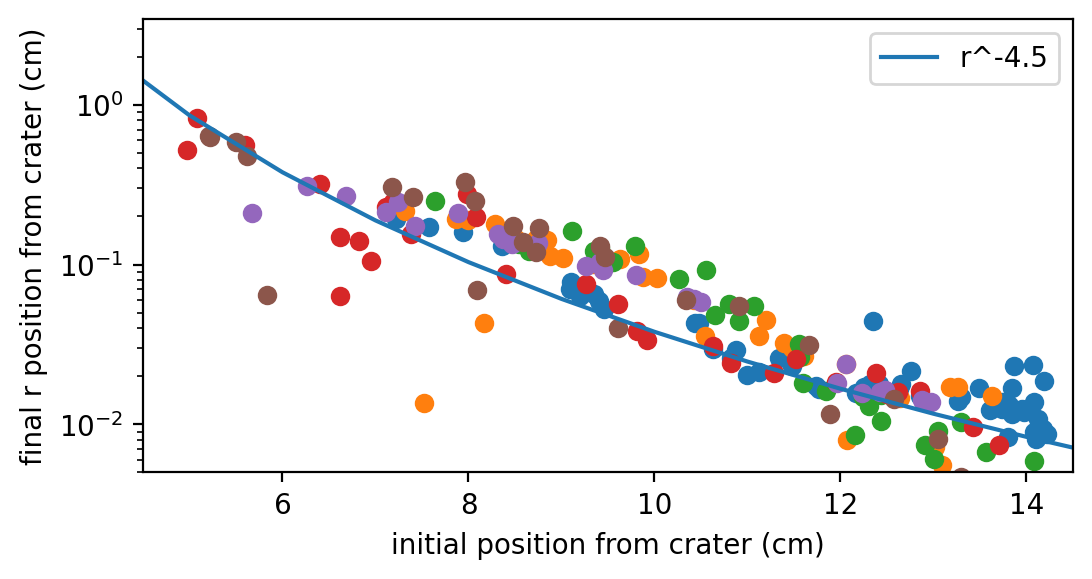

In [7]:
plt.figure(figsize=(6,3),dpi=200);
for i in range(6):
    plt.scatter(total[i,0,:],total[i,1,:])
plt.plot(xs, power(xs,1200,(-4.5)), label = "r^-4.5")
plt.legend()
plt.xlim(4.5,14.5)
plt.yscale('log')
plt.ylim(0.005)
plt.xlabel("initial position from crater (cm)")
plt.ylabel("final r position from crater (cm)")

Text(0, 0.5, 'peak r position from crater (cm)')

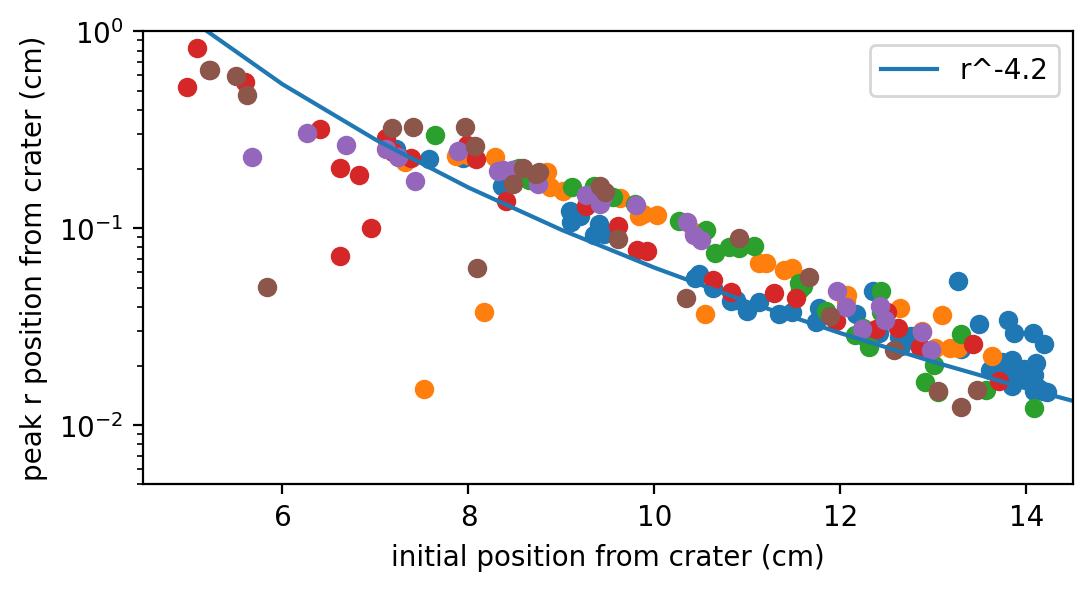

In [8]:
plt.figure(figsize=(6,3),dpi=200);
for i in range(6):
    plt.scatter(total[i,0,:],total[i,2,:])
plt.plot(xs, power(xs,1000,(-4.2)), label = "r^-4.2")
plt.legend()
plt.xlim(4.5,14.5)
plt.yscale('log')
plt.ylim(0.005,1)
plt.xlabel("initial position from crater (cm)")
plt.ylabel("peak r position from crater (cm)")

Vertical position curves (z-axis)

In [9]:
#load vertical displacements
s1z = pd.read_csv("PTV1sz.csv")
s2z = pd.read_csv("PTV2sz.csv")
s3z = pd.read_csv("PTV3sz.csv")

In [10]:
totalz = np.zeros((3,3,100)) #run number,init_pos or final_pos or peak_pos, particle number

#load initial position from side videos
totalz[0,0,:s1z.loc[:,"init_pos"].size]=s1z.loc[:,"init_pos"]
totalz[1,0,:s2z.loc[:,"init_pos"].size]=s2z.loc[:,"init_pos"]
totalz[2,0,:s3z.loc[:,"init_pos"].size]=s3z.loc[:,"init_pos"]

#load final position from side videos
totalz[0,1,:s1z.loc[:,"final_pos"].size]=s1z.loc[:,"final_pos"]
totalz[1,1,:s2z.loc[:,"final_pos"].size]=s2z.loc[:,"final_pos"]
totalz[2,1,:s3z.loc[:,"final_pos"].size]=s3z.loc[:,"final_pos"]

#load peak position from side videos
totalz[0,2,:s1z.loc[:,"peak_pos"].size]=s1z.loc[:,"peak_pos"]
totalz[1,2,:s2z.loc[:,"peak_pos"].size]=s2z.loc[:,"peak_pos"]
totalz[2,2,:s3z.loc[:,"peak_pos"].size]=s3z.loc[:,"peak_pos"]

Text(0, 0.5, 'final z position from crater (cm)')

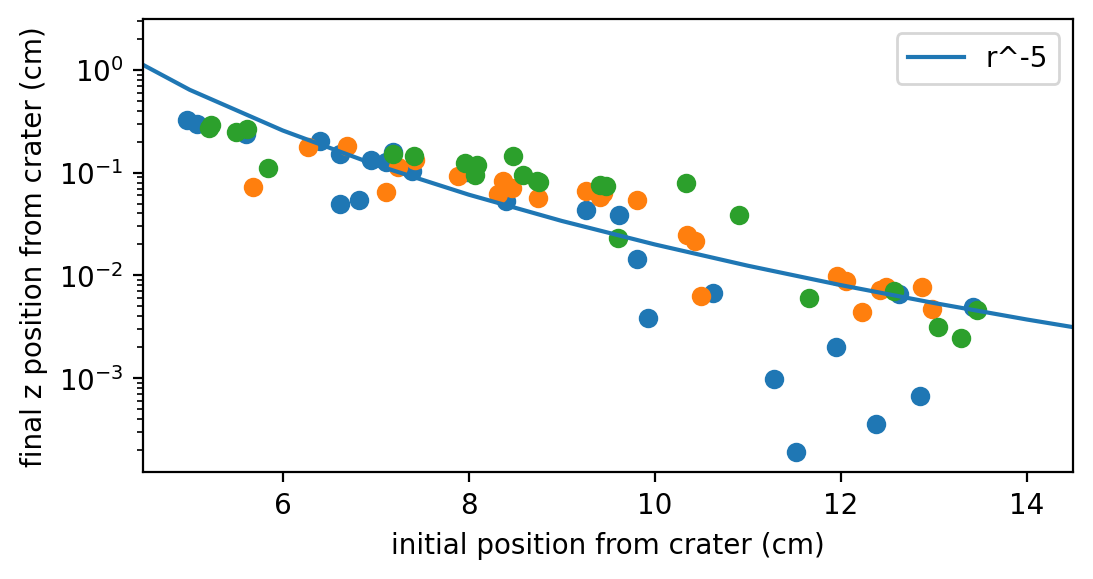

In [11]:
plt.figure(figsize=(6,3),dpi=200);
for i in range(3):
    plt.scatter(totalz[i,0,:],totalz[i,1,:])
plt.plot(xs, power(xs,2000,(-5)), label = "r^-5")
plt.legend()
plt.xlim(4.5,14.5)
plt.yscale('log')
plt.ylim()
plt.xlabel("initial position from crater (cm)")
plt.ylabel("final z position from crater (cm)")

Text(0, 0.5, 'peak z position from crater (cm)')

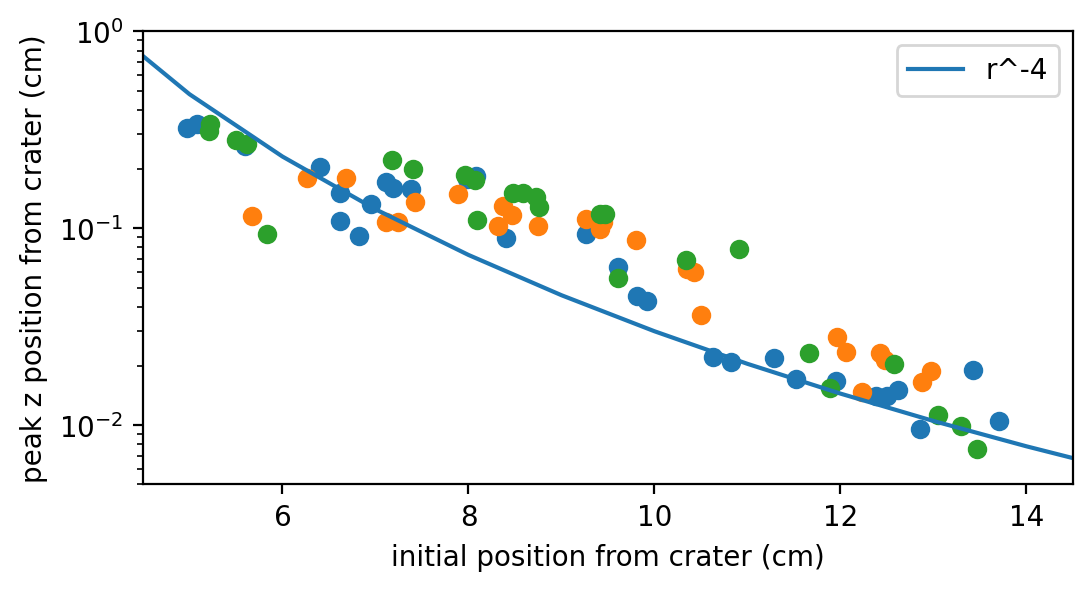

In [12]:
plt.figure(figsize=(6,3),dpi=200);
for i in range(3):
    plt.scatter(totalz[i,0,:],totalz[i,2,:])
plt.plot(xs, power(xs,300,(-4)), label = "r^-4")
plt.legend()
plt.xlim(4.5,14.5)
plt.yscale('log')
plt.ylim(0.005,1)
plt.xlabel("initial position from crater (cm)")
plt.ylabel("peak z position from crater (cm)")

Radial velocity curves

In [13]:
#load radial velocities
a1v = pd.read_csv("PTV1av.csv")
s1v = pd.read_csv("PTV1sv.csv")
a2v = pd.read_csv("PTV2av.csv")
s2v = pd.read_csv("PTV2sv.csv")
a3v = pd.read_csv("PTV3av.csv")
s3v = pd.read_csv("PTV3sv.csv")

In [15]:
totalv = np.zeros((6,2,100)) #run number,init_pos or peak_vel, particle number

#load initial position from above videos
totalv[0,0,:a1v.loc[:,"init_pos"].size]=a1v.loc[:,"init_pos"]
totalv[1,0,:a2v.loc[:,"init_pos"].size]=a2v.loc[:,"init_pos"]
totalv[2,0,:a3v.loc[:,"init_pos"].size]=a3v.loc[:,"init_pos"]
#load initial position from side videos
totalv[3,0,:s1v.loc[:,"init_pos"].size]=s1v.loc[:,"init_pos"]
totalv[4,0,:s2v.loc[:,"init_pos"].size]=s2v.loc[:,"init_pos"]
totalv[5,0,:s3v.loc[:,"init_pos"].size]=s3v.loc[:,"init_pos"]

#load peak velocity from above videos
totalv[0,1,:a1v.loc[:,"peak_vel"].size]=a1v.loc[:,"peak_vel"]
totalv[1,1,:a2v.loc[:,"peak_vel"].size]=a2v.loc[:,"peak_vel"]
totalv[2,1,:a3v.loc[:,"peak_vel"].size]=a3v.loc[:,"peak_vel"]
#load peak velocity from side videos
totalv[3,1,:s1v.loc[:,"peak_vel"].size]=s1v.loc[:,"peak_vel"]
totalv[4,1,:s2v.loc[:,"peak_vel"].size]=s2v.loc[:,"peak_vel"]
totalv[5,1,:s3v.loc[:,"peak_vel"].size]=s3v.loc[:,"peak_vel"]

Text(0, 0.5, 'peak r velocity (m/s)')

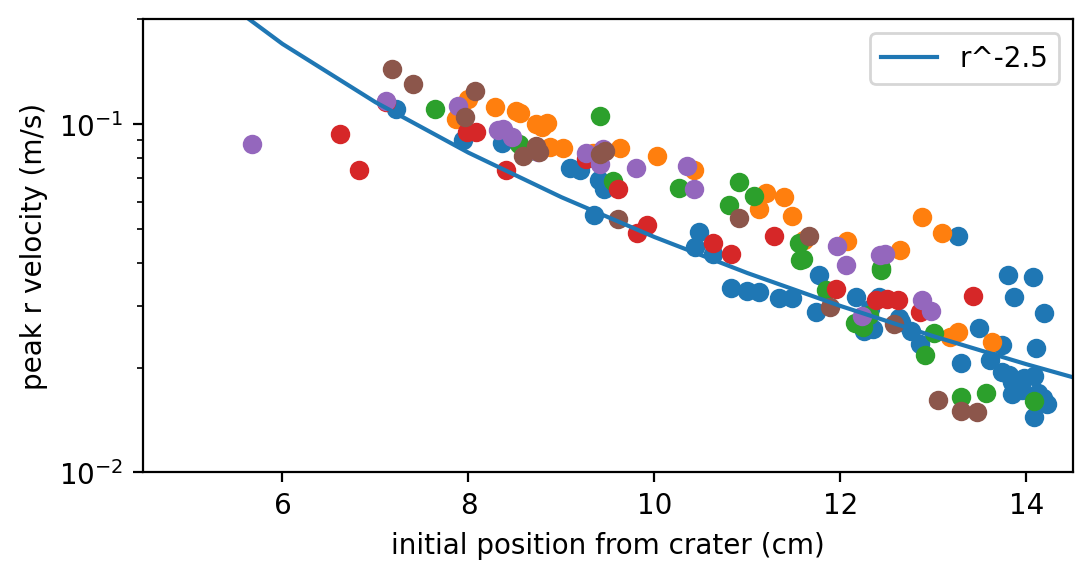

In [16]:
plt.figure(figsize=(6,3),dpi=200);
for i in range(6):
    plt.scatter(totalv[i,0,:],totalv[i,1,:]/100)
plt.plot(xs, power(xs,15,(-2.5)), label = "r^-2.5")
plt.legend()
plt.xlim(4.5,14.5)
plt.yscale('log')
plt.ylim(.01,.2)
plt.xlabel("initial position from crater (cm)")
plt.ylabel("peak r velocity (m/s)")

In [17]:
#load vertical velocities
s1vz = pd.read_csv("PTV1svz.csv")
s2vz = pd.read_csv("PTV2svz.csv")
s3vz = pd.read_csv("PTV3svz.csv")

In [18]:
totalvz = np.zeros((3,2,100)) #run number,init_pos or peak_vel, particle number

#load initial position from side videos
totalvz[0,0,:s1vz.loc[:,"init_pos"].size]=s1vz.loc[:,"init_pos"]
totalvz[1,0,:s2vz.loc[:,"init_pos"].size]=s2vz.loc[:,"init_pos"]
totalvz[2,0,:s3vz.loc[:,"init_pos"].size]=s3vz.loc[:,"init_pos"]

#load peak velocity from side videos
totalvz[0,1,:s1vz.loc[:,"zpeak_vel"].size]=s1vz.loc[:,"zpeak_vel"]
totalvz[1,1,:s2vz.loc[:,"zpeak_vel"].size]=s2vz.loc[:,"zpeak_vel"]
totalvz[2,1,:s3vz.loc[:,"zpeak_vel"].size]=s3vz.loc[:,"zpeak_vel"]

Text(0, 0.5, 'peak z velocity (m/s)')

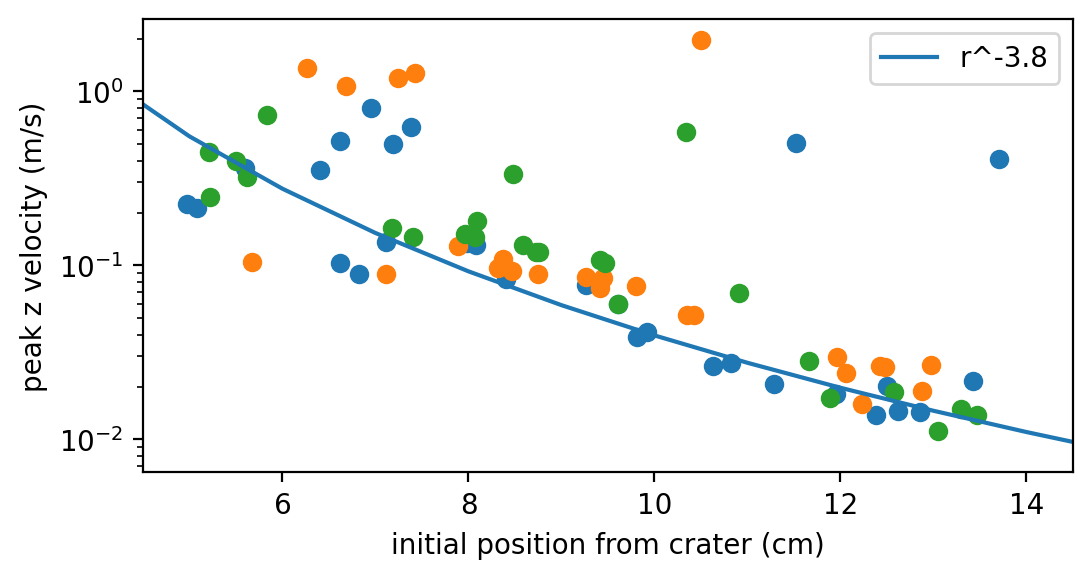

In [19]:
plt.figure(figsize=(6,3),dpi=200);
for i in range(3):
    plt.scatter(totalvz[i,0,:],totalvz[i,1,:]/100)
plt.plot(xs, power(xs,250,(-3.8)), label = "r^-3.8")
plt.legend()
plt.xlim(4.5,14.5)
plt.yscale('log')
#plt.ylim(.01,.2)
plt.xlabel("initial position from crater (cm)")
plt.ylabel("peak z velocity (m/s)")

Text(0.5, 0, 'initial position in cm')

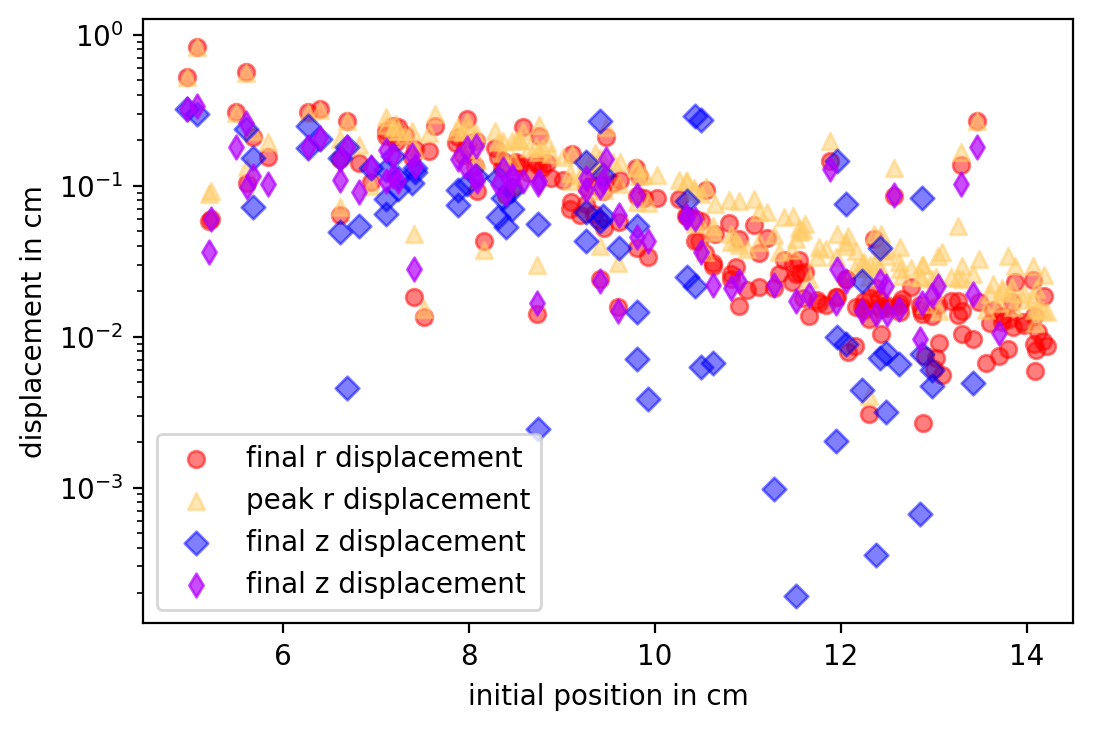

In [20]:
plt.figure(figsize=(6,4),dpi=200);
#final radial position
for i in range(5):
    plt.scatter(total[i,0,:],total[i,1,:], marker="o", color=(1,0,0,0.5))
plt.scatter(total[5,0,:],total[i,1,:], marker="o",color=(1,0,0,0.5), label="final r displacement")
#peak radial position 
for i in range(5):
    plt.scatter(total[i,0,:],total[i,2,:], marker="^",color=(1, 0.8, 0.4, 0.5))
plt.scatter(total[5,0,:],total[i,2,:], marker="^",color=(1, 0.8, 0.4, 0.5), label="peak r displacement")
#final vertical position
for i in range(2):
    plt.scatter(totalz[i,0,:],totalz[i,1,:], marker="D", color=(0,0,1,0.5))
plt.scatter(totalz[i,0,:],totalz[2,1,:], marker="D", color=(0,0,1,0.5), label="final z displacement")
#peak vertical position
for i in range(2):
    plt.scatter(totalz[i,0,:],totalz[i,2,:], marker="d", color=(0.7,0,1,0.7))
plt.scatter(totalz[2,0,:],totalz[i,2,:], marker="d", color=(0.7,0,1,0.7), label="final z displacement")

#plt.plot(xs, power(xs,15,(-2.5),0), label = "r^-2.5")
plt.xlim(4.5,14.5)
plt.yscale('log')
plt.legend()
plt.ylabel('displacement in cm')
plt.xlabel('initial position in cm')

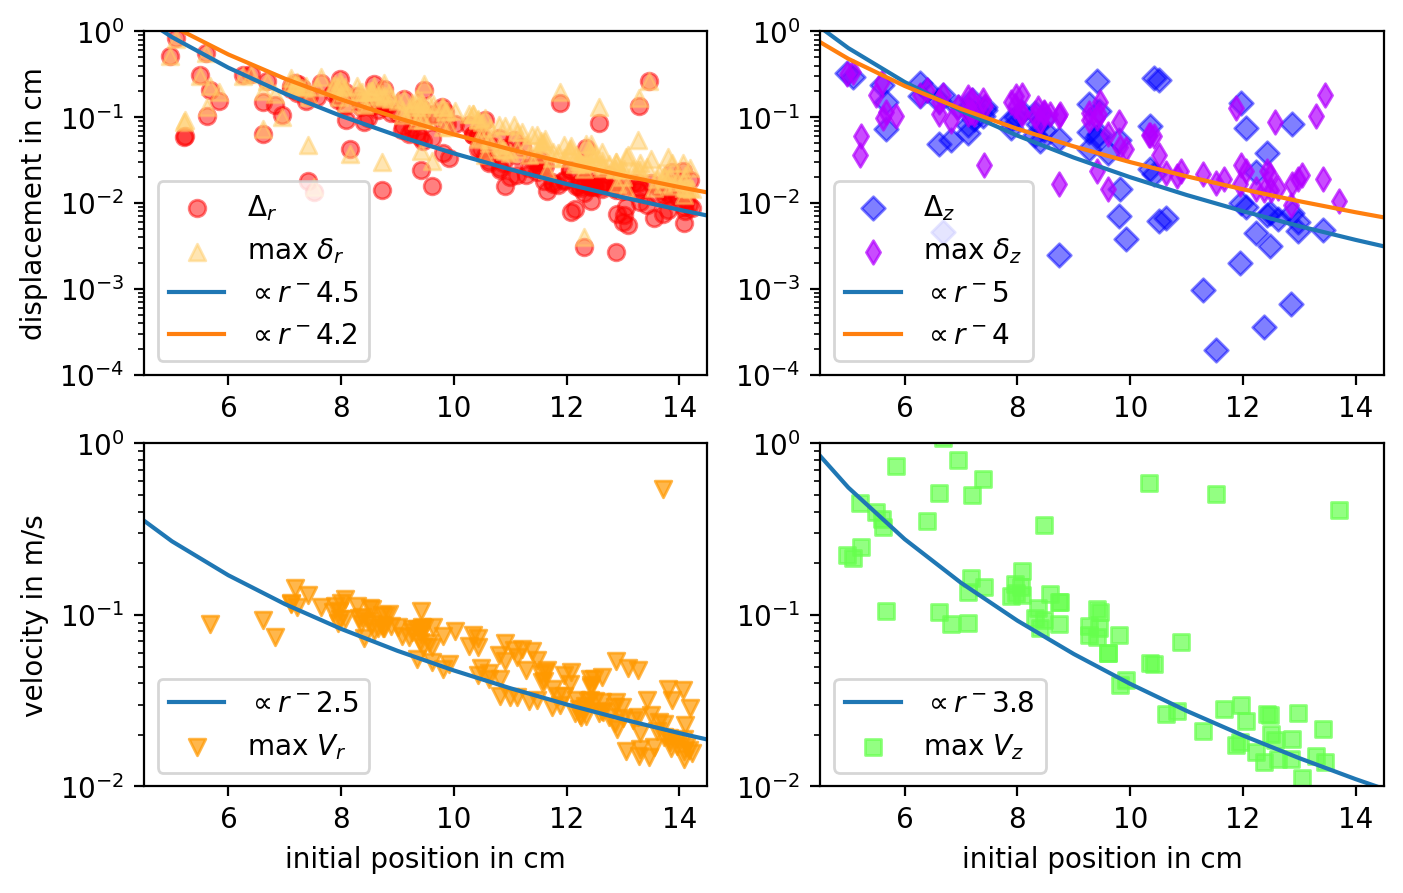

In [21]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8,5), dpi=200)

for i in range(5):
    ax1.scatter(total[i,0,:],total[i,1,:], marker="o", color=(1,0,0,0.5))
ax1.scatter(total[5,0,:],total[i,1,:], marker="o",color=(1,0,0,0.5), label="$\Delta_r$")
#peak radial position 
for i in range(5):
    ax1.scatter(total[i,0,:],total[i,2,:], marker="^",color=(1, 0.8, 0.4, 0.5))
ax1.scatter(total[5,0,:],total[i,2,:], marker="^",color=(1, 0.8, 0.4, 0.5), label="max $\delta_r$")

for i in range(2):
    ax2.scatter(totalz[i,0,:],totalz[i,1,:], marker="D", color=(0,0,1,0.5))
ax2.scatter(totalz[i,0,:],totalz[2,1,:], marker="D", color=(0,0,1,0.5), label="$\Delta_z$")
#peak vertical position
for i in range(2):
    ax2.scatter(totalz[i,0,:],totalz[i,2,:], marker="d", color=(0.7,0,1,0.7))
ax2.scatter(totalz[2,0,:],totalz[i,2,:], marker="d", color=(0.7,0,1,0.7), label="max $\delta_z$")

#"fits" (done by hand)
ax1.plot(xs, power(xs,1200,(-4.5)), label = "$\propto r^-4.5$")
ax1.plot(xs, power(xs,1000,(-4.2)), label = "$\propto r^-4.2$")
ax2.plot(xs, power(xs,2000,(-5)), label = "$\propto r^-5$")
ax2.plot(xs, power(xs,300,(-4)), label = "$\propto r^-4$")
ax3.plot(xs, power(xs,15,(-2.5)), label = "$\propto r^-2.5$")
ax4.plot(xs, power(xs,250,(-3.8)), label = "$\propto r^-3.8$")

ax1.set_xlim(4.5,14.5)
ax2.set_xlim(4.5,14.5)
ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.legend()
ax2.legend()
ax1.set_ylabel('displacement in cm')
#ax1.set_xlabel('initial position in cm')
#ax2.set_ylabel('displacement in cm')
#ax2.set_xlabel('initial position in cm')
ax1.set_ylim(.0001,1)
ax2.set_ylim(.0001,1)
#ax2. yaxis. set_visible(False)

for i in range(5):
    ax3.scatter(totalv[i,0,:],totalv[i,1,:]/100,  marker="v", color=(1,0.6,0,0.7))
ax3.scatter(totalv[5,0,:],totalv[5,1,:]/100,  marker="v", color=(1,0.6,0,0.7), label = "max $V_r$")
    
for i in range(2):
    ax4.scatter(totalvz[i,0,:],totalvz[i,1,:]/100,  marker="s", color=(0.4,1,0.3,0.7))
ax4.scatter(totalvz[2,0,:],totalvz[2,1,:]/100,  marker="s", color=(0.4,1,0.3,0.7), label = "max $V_z$")
    
ax3.set_xlim(4.5,14.5)
ax4.set_xlim(4.5,14.5)
ax3.set_yscale('log')
ax4.set_yscale('log')
ax3.legend()
ax4.legend()
ax3.set_ylabel('velocity in m/s')
ax3.set_xlabel('initial position in cm')
#ax2.set_ylabel('displacement in cm')
ax4.set_xlabel('initial position in cm')
ax3.set_ylim(.01,1)
ax4.set_ylim(.01,1)
#ax4. yaxis. set_visible(False)

plt.show()

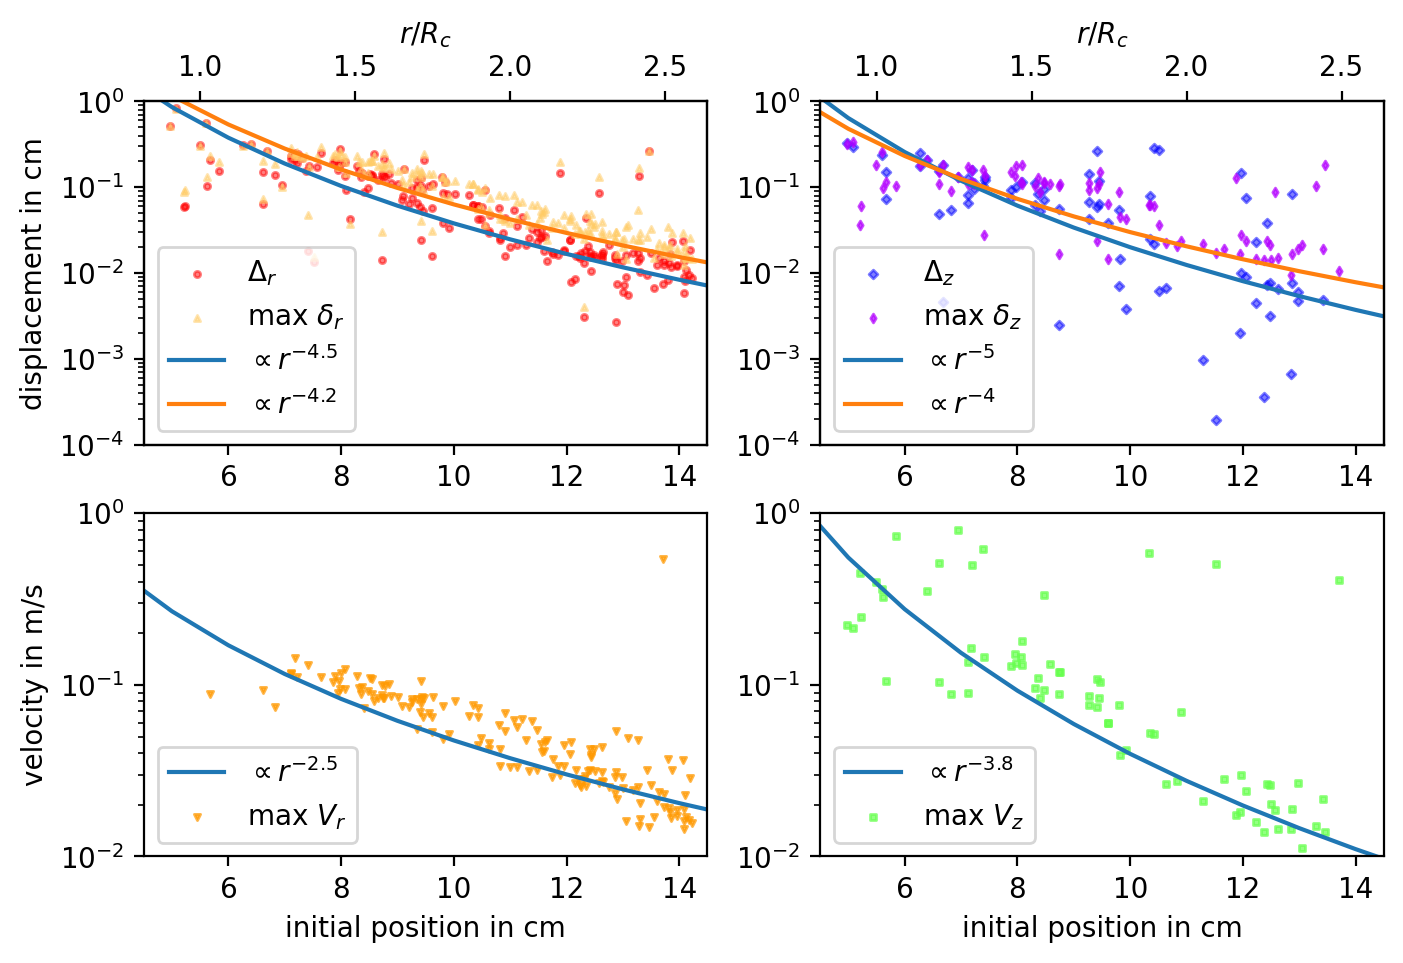

In [22]:
#fig = plt.figure(figsize=(7,5),dpi=200)
#gs = fig.add_gridspec(2, 2, hspace=0.1, wspace=0)
#(ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8,5), dpi=200)

for i in range(5):
    ax1.scatter(total[i,0,:],total[i,1,:], marker="o", color=(1,0,0,0.5), s=5)
ax1.scatter(total[5,0,:],total[i,1,:], marker="o",color=(1,0,0,0.5), s=5, label="$\Delta_r$")
#peak radial position 
for i in range(5):
    ax1.scatter(total[i,0,:],total[i,2,:], marker="^",color=(1, 0.8, 0.4, 0.5), s=5)
ax1.scatter(total[5,0,:],total[i,2,:], marker="^",color=(1, 0.8, 0.4, 0.5), s=5, label="max $\delta_r$")

for i in range(2):
    ax2.scatter(totalz[i,0,:],totalz[i,1,:], marker="D", color=(0,0,1,0.5), s=5)
ax2.scatter(totalz[i,0,:],totalz[2,1,:], marker="D", color=(0,0,1,0.5), s=5, label="$\Delta_z$")
#peak vertical position
for i in range(2):
    ax2.scatter(totalz[i,0,:],totalz[i,2,:], marker="d", color=(0.7,0,1,0.7), s=5)
ax2.scatter(totalz[2,0,:],totalz[i,2,:], marker="d", color=(0.7,0,1,0.7), s=5, label="max $\delta_z$")

#"fits" (done by hand)
ax1.plot(xs, power(xs,1200,(-4.5)), label = "$\propto r^{-4.5}$")
ax1.plot(xs, power(xs,1000,(-4.2)), label = "$\propto r^{-4.2}$")
ax2.plot(xs, power(xs,2000,(-5)), label = "$\propto r^{-5}$")
ax2.plot(xs, power(xs,300,(-4)), label = "$\propto r^{-4}$")
ax3.plot(xs, power(xs,15,(-2.5)), label = "$\propto r^{-2.5}$")
ax4.plot(xs, power(xs,250,(-3.8)), label = "$\propto r^{-3.8}$")

xmin = 4.5
xmax = 14.5
ax1.set_xlim(4.5,14.5)
ax2.set_xlim(4.5,14.5)
ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.legend()
ax2.legend()
ax1.set_ylabel('displacement in cm')
#ax1.set_xlabel('initial position in cm')
#ax2.set_ylabel('displacement in cm')
#ax2.set_xlabel('initial position in cm')
ax1.set_ylim(.0001,1)
ax2.set_ylim(.0001,1)
axi2 = ax1.twiny()
Rcr = 5.5 #crater radius in cm 
axi2.set_xlim([xmin/Rcr,xmax/Rcr]) 
axi2.set_xlabel("$r/R_c$")
axi5 = ax2.twiny()
axi5.set_xlim([xmin/Rcr,xmax/Rcr])
axi5.set_xlabel("$r/R_c$")
#ax2. yaxis. set_visible(False)

for i in range(5):
    ax3.scatter(totalv[i,0,:],totalv[i,1,:]/100,  marker="v", color=(1,0.6,0,0.7), s=5)
ax3.scatter(totalv[5,0,:],totalv[5,1,:]/100,  marker="v", color=(1,0.6,0,0.7), s=5, label = "max $V_r$")
    
for i in range(2):
    ax4.scatter(totalvz[i,0,:],totalvz[i,1,:]/100,  marker="s", color=(0.4,1,0.3,0.7), s=5)
ax4.scatter(totalvz[2,0,:],totalvz[2,1,:]/100,  marker="s", color=(0.4,1,0.3,0.7), s=5, label = "max $V_z$")
    
ax3.set_xlim(4.5,14.5)
ax4.set_xlim(4.5,14.5)
ax3.set_yscale('log')
ax4.set_yscale('log')
ax3.legend()
ax4.legend()
ax3.set_ylabel('velocity in m/s')
ax3.set_xlabel('initial position in cm')
#ax2.set_ylabel('displacement in cm')
ax4.set_xlabel('initial position in cm')
ax3.set_ylim(.01,1)
ax4.set_ylim(.01,1)
#ax4. yaxis. set_visible(False)
ax1.legend(loc='lower left')
ax3.legend(loc='lower left')
plt.show()

#do fits, add error bars
#do another derivative to get acceleration exponent
#do scaling stuff (divide by momentum?)
#error in initial position ~0.3 cm, error in displacement ~3.5 pixels (grain size) which is .02 cm

In [23]:
tdr_finals = [] #total displacement radial final
tdr_initials = []
tdr_peaks = []

for i in range(6):
    for j in range(100):
        if (total[i,0,j] != 0):
            tdr_initials.append(total[i,0,j])
            tdr_finals.append(total[i,1,j])
            tdr_peaks.append(total[i,2,j])

In [24]:
#tdz_finals.clear() #total displacement vertical final
#tdz_initials.clear()
#tdz_peaks.clear()

tdz_finals = []
tdz_initials = []
tdz_peaks = []

for i in range(3):
    for j in range(100):
        if (totalz[i,0,j] != 0):
            tdz_initials.append(totalz[i,0,j])
            tdz_finals.append(totalz[i,1,j])
            tdz_peaks.append(totalz[i,2,j])

In [25]:
#tvr_initials.clear()
#tvr_peaks.clear()
#tvz_initials.clear()
#tvz_peaks.clear()

tvr_initials = []
tvr_peaks = []
tvz_initials = []
tvz_peaks = []

for i in range(6):
    for j in range(100):
        if (totalv[i,1,j] != 0 and totalv[i,1,j]<=20):
            tvr_initials.append(totalv[i,0,j])
            tvr_peaks.append(totalv[i,1,j]/100)
            
for i in range(3):
    for j in range(100):
        if (totalvz[i,1,j] != 0 and totalvz[i,1,j]<=20):
            tvz_initials.append(totalvz[i,0,j])
            tvz_peaks.append(totalvz[i,1,j]/100)

In [27]:
R = 5.5

In [28]:
def pwr(p,x):
    a,b = p
    return a/(R**b)*(x**b)
power_model = odr.Model(pwr)

In [29]:
power_model = odr.Model(pwr)

In [30]:
parameters1 = np.zeros((6,4)) #(data that was fit; parameter a,b, error a,b)

#radial displacement
data = odr.RealData(tdr_initials, tdr_finals, sx=xerr, sy=yerr)
Odr = odr.ODR(data, power_model, beta0=[1200., -4.5])
out = Odr.run()
popt = out.beta
perr = out.sd_beta
print('———————————–')
print('radial disp fit parameter 1-sigma error')
for i in range(len(popt)):
    print(str(popt[i])+'\t'+str(perr[i]))
print(out.res_var)

parameters1[0,:2] = popt[:]
parameters1[0,2:4] = perr[:]
    
#radial peak displacement
data = odr.RealData(tdr_initials, tdr_peaks, sx=xerr, sy=yerr)
Odr = odr.ODR(data, power_model, beta0=[1200., -4.5])
out = Odr.run()
popt = out.beta
perr = out.sd_beta
print('———————————–')
print('radial peak disp fit parameter 1-sigma error')
for i in range(len(popt)):
    print(str(popt[i])+'\t'+str(perr[i]))
print(out.res_var)

parameters1[1,:2] = popt[:]
parameters1[1,2:4] = perr[:]
    
#vertical displacement
data = odr.RealData(tdz_initials, tdz_finals, sx=xerr, sy=yerr)
Odr = odr.ODR(data, power_model, beta0=[2000., -5.0])
out = Odr.run()
popt = out.beta
perr = out.sd_beta
print('———————————–')
print('vertical disp fit parameter 1-sigma error')
for i in range(len(popt)):
    print(str(popt[i])+'\t'+str(perr[i]))
print(out.res_var)

parameters1[2,:2] = popt[:]
parameters1[2,2:4] = perr[:]
    
#vertical peak displacement
data = odr.RealData(tdz_initials, tdz_peaks, sx=xerr, sy=yerr)
Odr = odr.ODR(data, power_model, beta0=[2000., -5.0])
out = Odr.run()
popt = out.beta
perr = out.sd_beta
print('———————————–')
print('vertical peak disp fit parameter 1-sigma error')
for i in range(len(popt)):
    print(str(popt[i])+'\t'+str(perr[i]))
print(out.res_var)

parameters1[3,:2] = popt[:]
parameters1[3,2:4] = perr[:]
    
#radial peak velocity
data = odr.RealData(tvr_initials, tvr_peaks, sx=xerr, sy=yerr/100)
Odr = odr.ODR(data, power_model, beta0=[2000., -5.0])
out = Odr.run()
popt = out.beta
perr = out.sd_beta
print('———————————–')
print('radial peak vel fit parameter 1-sigma error')
for i in range(len(popt)):
    print(str(popt[i])+'\t'+str(perr[i]))
print(out.res_var)

parameters1[4,:2] = popt[:]
parameters1[4,2:4] = perr[:]
    
#vertical peak velocity
data = odr.RealData(tvz_initials, tvz_peaks, sx=xerr, sy=yerr/100)
Odr = odr.ODR(data, power_model, beta0=[2000., -5.0])
out = Odr.run()
popt = out.beta
perr = out.sd_beta
print('———————————–')
print('vertical peak vel fit parameter 1-sigma error')
for i in range(len(popt)):
    print(str(popt[i])+'\t'+str(perr[i]))
print(out.res_var)    
parameters1[5,:2] = popt[:]
parameters1[5,2:4] = perr[:]

———————————–
radial disp fit parameter 1-sigma error
0.659635998207562	0.051844563177049566
-4.038761333945349	0.18173418875982697
2.2445155115581352
———————————–
radial peak disp fit parameter 1-sigma error
0.6609474780084547	0.04729645673541985
-3.4338501839856805	0.1523799013613918
2.851167998295822
———————————–
vertical disp fit parameter 1-sigma error
0.2645248547291778	0.01982793633495679
-3.249295356883419	0.2393860424363587
1.8364723148036235
———————————–
vertical peak disp fit parameter 1-sigma error
0.2953155550488911	0.020635057597547725
-2.5575594473958048	0.19343565801394355
2.6049515116032715
———————————–
radial peak vel fit parameter 1-sigma error
0.5163269461096552	0.05464754985422288
-3.5499095204047846	0.14011387806773412
9.33460613993506
———————————–
vertical peak vel fit parameter 1-sigma error
0.712589496283626	0.12958306397488842
-4.4890337916703595	0.2675390831595271
8.03406634874159


In [31]:
peak_velx = np.array(pd.read_csv("SZ0_xvel.csv"))
peak_vely = np.array(pd.read_csv("SZ0_yvel.csv"))

In [32]:
peak_velx[:,2]

array([0.10853541, 0.06311103, 0.028033  , 0.0246445 , 0.120304  ,
       0.07385392, 0.0364581 , 0.01739718, 0.09938575, 0.05258131,
       0.03684919, 0.02589037])

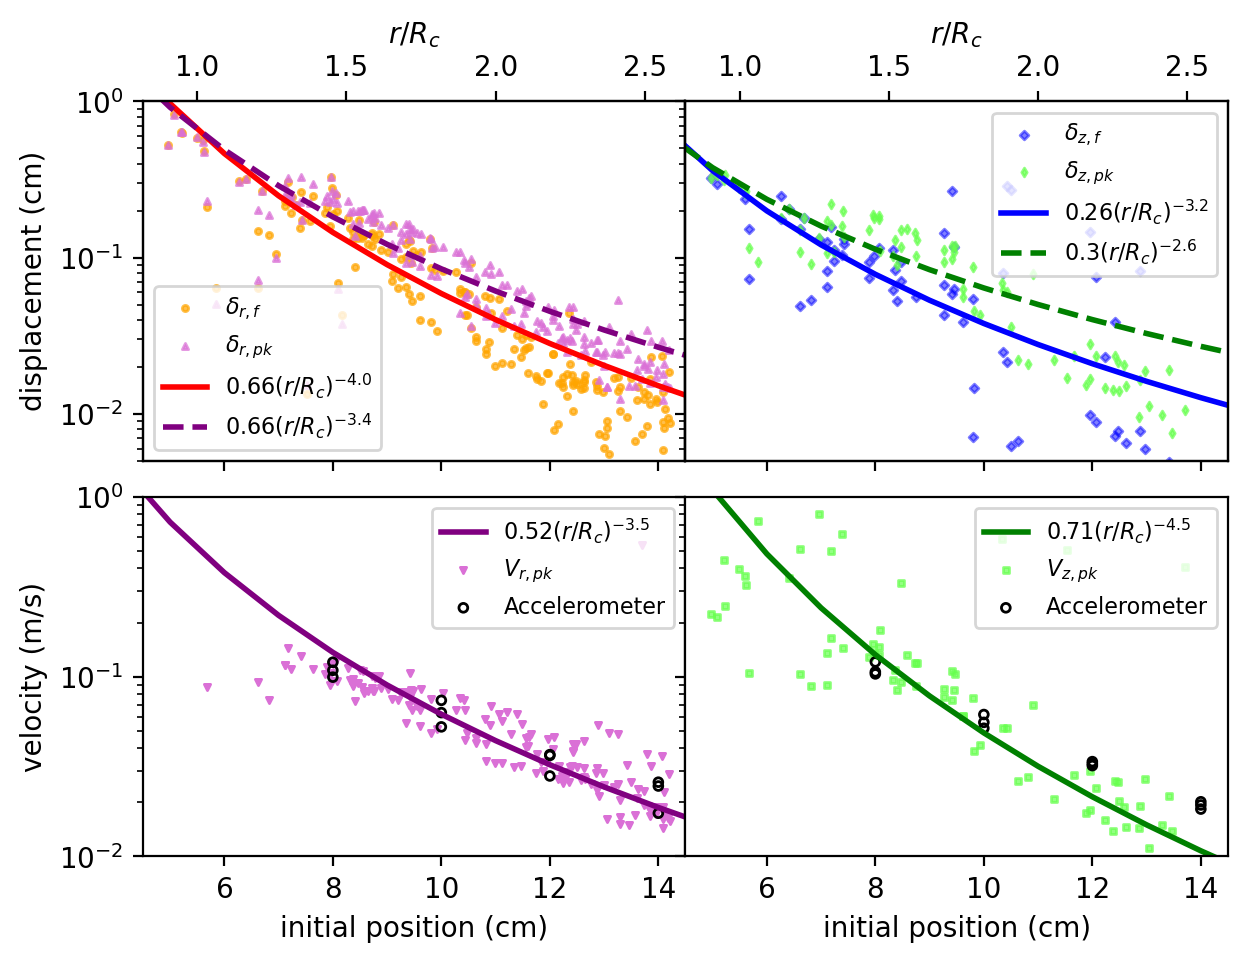

In [33]:
fig = plt.figure(figsize=(7,5),dpi=200)
gs = fig.add_gridspec(2, 2, hspace=0.1, wspace=0)
(ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')

#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8,5), dpi=200)

alpha=0.7
for i in range(5):
    ax1.scatter(total[i,0,:],total[i,1,:], marker="o", color="orange", s=5, alpha=alpha)
ax1.scatter(total[5,0,:],total[5,1,:], marker="o",color="orange", s=5, label="$\delta_{r,f}$", alpha=alpha)
#peak radial position 
for i in range(5):
    ax1.scatter(total[i,0,:],total[i,2,:], marker="^",color='orchid', s=5,zorder=1, alpha=alpha)
ax1.scatter(total[5,0,:],total[5,2,:], marker="^",color='orchid', s=5, label="$\delta_{r,pk}$",zorder=2, alpha=alpha)


for i in range(2):
    ax2.scatter(totalz[i,0,:],totalz[i,1,:], marker="D", color=(0,0,1,0.5), s=5) #(0,0,1,0.5)
ax2.scatter(totalz[i,0,:],totalz[2,1,:], marker="D", color=(0,0,1,0.5), s=5, label="$\delta_{z,f}$")

#peak vertical position
for i in range(2):
    ax2.scatter(totalz[i,0,:],totalz[i,2,:], marker="d", color=(0.4,1,0.3,0.7), s=5)
ax2.scatter(totalz[2,0,:],totalz[2,2,:], marker="d", color=(0.4,1,0.3,0.7), s=5, label="$\delta_{z,pk}$")

#"fits" (done by hand)
string = "4.6"
ax1.plot(xs, pwr((parameters1[0,0],parameters1[0,1]),xs), label = '$' + str(round(parameters1[0,0],2)) + "(r/R_c)^{" + str(round(parameters1[0,1],1)) + "}$", c = 'red', lw = 2)
ax1.plot(xs, pwr((parameters1[1,0],parameters1[1,1]),xs), label = '$' + str(round(parameters1[1,0],2)) + "(r/R_c)^{" + str(round(parameters1[1,1],1)) + "}$", c = 'purple', ls = "--", lw = 2)
ax2.plot(xs, pwr((parameters1[2,0],parameters1[2,1]),xs), label = '$' + str(round(parameters1[2,0],2)) + "(r/R_c)^{" + str(round(parameters1[2,1],1)) + "}$", c = 'blue', lw=2)
ax2.plot(xs, pwr((parameters1[3,0],parameters1[3,1]),xs), label = '$' + str(round(parameters1[3,0],2)) + "(r/R_c)^{" + str(round(parameters1[3,1],1)) + "}$", c = 'green', ls = '--', lw = 2)
ax3.plot(xs, pwr((parameters1[4,0],parameters1[4,1]),xs), label = '$' + str(round(parameters1[4,0],2)) + "(r/R_c)^{" + str(round(parameters1[4,1],1)) + "}$", c = 'purple', lw = 2)
ax4.plot(xs, pwr((parameters1[5,0],parameters1[5,1]),xs), label = '$' + str(round(parameters1[5,0],2)) + "(r/R_c)^{" + str(round(parameters1[5,1],1)) + "}$", c = 'green', lw = 2)


xmin = 4.5
xmax = 14.5
ax1.set_xlim(4.5,14.5)
ax2.set_xlim(4.5,14.5)
ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.legend()
ax2.legend()
ax1.set_ylabel('displacement (cm)')
#ax1.set_xlabel('initial position in cm')
#ax2.set_ylabel('displacement in cm')
#ax2.set_xlabel('initial position in cm')
ax1.set_ylim(.005,1)
ax2.set_ylim(.005,1)
axi2 = ax1.twiny()
Rcr = 5.5 #crater radius in cm 
axi2.set_xlim([xmin/Rcr,xmax/Rcr]) 
axi2.set_xlabel("$r/R_c$")
axi5 = ax2.twiny()
axi5.set_xlim([xmin/Rcr,xmax/Rcr])
axi5.set_xlabel("$r/R_c$")
#ax2. yaxis. set_visible(False)

for i in range(5):
    ax3.scatter(totalv[i,0,:],totalv[i,1,:]/100,  marker="v", color='orchid', s=5) #(1,0.6,0,0.7)
ax3.scatter(totalv[5,0,:],totalv[5,1,:]/100,  marker="v", color='orchid', s=5, label = "$V_{r,pk}$")


for i in range(2):
    ax4.scatter(totalvz[i,0,:],totalvz[i,1,:]/100,  marker="s", color=(0.4,1,0.3,0.7), s=5)
ax4.scatter(totalvz[2,0,:],totalvz[2,1,:]/100,  marker="s", color=(0.4,1,0.3,0.7), s=5, label = "$V_{z,pk}$")

#for i in range(6):
    #ax1.errorbar(total[i,0,:],total[i,1,:], xerr = 0.3, yerr = 0.01, fmt="none")

xerr = 0.3   #cm
yerr = 0.02  #cm half a grain radius

#pars, cov = curve_fit(f=power, xdata=tvr_initials, ydata=tvr_peaks, p0=[15, -2.5], bounds=(-np.inf, np.inf))
#ax3.plot(xs,power(xs, pars[0], pars[1]), linestyle='--', linewidth=2, color='black') #power(xs, 62.90126299, 0.5574180747)
#ax3.plot(xs,power(xs, 16.5, -2.45), linestyle='--', linewidth=2, color='black') #power(xs, 62.90126299, 0.5574180747)
#print(pars)
#print(cov)

ax3.scatter(peak_velx[:,1], peak_velx[:,2], marker = "o", s = 10, label = "Accelerometer", facecolors='none', edgecolors='k') #(0.5,0.5,0.5,1)
ax4.scatter(peak_vely[:,1], peak_vely[:,2], marker = "o", s = 10, label = "Accelerometer", facecolors='none', edgecolors='k')

ax3.set_xlim(4.5,14.5)
ax4.set_xlim(4.5,14.5)
ax3.set_yscale('log')
ax4.set_yscale('log')
ax3.legend()
ax4.legend()
ax3.set_ylabel('velocity (m/s)')
ax3.set_xlabel('initial position (cm)')
#ax2.set_ylabel('displacement in cm')
ax4.set_xlabel('initial position (cm)')
ax3.set_ylim(.01,1)
ax4.set_ylim(.01,1)
#ax4. yaxis. set_visible(False)
ax1.legend(loc='lower left')
ax3.legend(loc='upper right')
ax4.legend(loc='upper right')

ax1.legend(labelspacing = 0.2)
ax2.legend(labelspacing = 0.2)
ax3.legend(labelspacing = 0.2)
ax4.legend(labelspacing = 0.2)

ax1.legend(prop={'size': 8})
ax2.legend(prop={'size': 8})
ax3.legend(loc='upper right', prop ={'size': 8})
ax4.legend(loc='upper right', prop ={'size': 8})

plt.show()

fig.savefig("power_law.png", dpi=500)
#do fits, add error bars
#do another derivative to get acceleration exponent
#do scaling stuff (divide by momentum?)
#error in initial position ~0.3 cm, error in displacement ~3.5 pixels (grain radius) which is .02 cm

In [34]:
def pwr2(p,x):
    a,b = p
    return parameters1[4,0]/(R**parameters1[4,1])*(x**parameters1[4,1])
power_model = odr.Model(pwr2)

def pwr3(p,x):
    a,b = p
    return parameters1[5,0]/(R**parameters1[5,1])*(x**parameters1[5,1])


#radial peak velocity
data = odr.RealData(tvr_initials, tvr_peaks, sx=xerr, sy=yerr/1)
Odr = odr.ODR(data, power_model, beta0=[2000., -5.0])
out = Odr.run()
popt = out.beta
perr = out.sd_beta
print('———————————–')
print('radial peak vel fit parameter 1-sigma error')
for i in range(len(popt)):
    print(str(popt[i])+'\t'+str(perr[i]))
print(out.res_var)

#parameters1[4,:2] = popt[:]
#parameters1[4,2:4] = perr[:]

power_model = odr.Model(pwr3)

#vertical peak velocity
data = odr.RealData(tvz_initials, tvz_peaks, sx=xerr, sy=yerr/0.5)
Odr = odr.ODR(data, power_model, beta0=[2000., -5.0])
out = Odr.run()
popt = out.beta
perr = out.sd_beta
print('———————————–')
print('vertical peak vel fit parameter 1-sigma error')
for i in range(len(popt)):
    print(str(popt[i])+'\t'+str(perr[i]))
print(out.res_var)    


———————————–
radial peak vel fit parameter 1-sigma error
2000.0	0.0
-5.0	0.0
1.2374947024093643
———————————–
vertical peak vel fit parameter 1-sigma error
2000.0	0.0
-5.0	0.0
1.2449839228335888


In [35]:
def expo(p,x):
    a,b = p
    return a*np.exp((x-R)/(R*b))
exp_model = odr.Model(expo)

In [36]:
#array for storing fitted parameters, errors
parameters = np.zeros((6,4)) #(data that was fit; parameter a,b, error a,b)

#radial displacement
data = odr.RealData(tdr_initials, tdr_finals, sx=xerr, sy=yerr)
Odr = odr.ODR(data, exp_model, beta0=[10., -4.5])
out = Odr.run()
popt = out.beta
perr = out.sd_beta
print('———————————–')
print('radial disp fit parameter 1-sigma error')
for i in range(len(popt)):
    print(str(popt[i])+'\t'+str(perr[i]))
print(out.res_var)

parameters[0,:2] = popt[:]
parameters[0,2:4] = perr[:]

#radial peak displacement
data = odr.RealData(tdr_initials, tdr_peaks, sx=xerr, sy=yerr)
Odr = odr.ODR(data, exp_model, beta0=[10., -4.5])
out = Odr.run()
popt = out.beta
perr = out.sd_beta
print('———————————–')
print('radial peak disp disp fit parameter 1-sigma error')
for i in range(len(popt)):
    print(str(popt[i])+'\t'+str(perr[i]))
print(out.res_var)

parameters[1,:2] = popt[:]
parameters[1,2:4] = perr[:]

#vertical displacement
data = odr.RealData(tdz_initials, tdz_finals, sx=xerr, sy=yerr)
Odr = odr.ODR(data, exp_model, beta0=[10., -4.5])
out = Odr.run()
popt = out.beta
perr = out.sd_beta
print('———————————–')
print('vertical disp fit parameter 1-sigma error')
for i in range(len(popt)):
    print(str(popt[i])+'\t'+str(perr[i]))
print(out.res_var)

parameters[2,:2] = popt[:]
parameters[2,2:4] = perr[:]

#vertical peak displacement
data = odr.RealData(tdz_initials, tdz_peaks, sx=xerr, sy=yerr)
Odr = odr.ODR(data, exp_model, beta0=[10., -4.5])
out = Odr.run()
popt = out.beta
perr = out.sd_beta
print('———————————–')
print('vertical peak disp fit parameter 1-sigma error')
for i in range(len(popt)):
    print(str(popt[i])+'\t'+str(perr[i]))
print(out.res_var)

parameters[3,:2] = popt[:]
parameters[3,2:4] = perr[:]

#radial peak velocity
data = odr.RealData(tvr_initials, tvr_peaks, sx=xerr, sy=yerr/100)
Odr = odr.ODR(data, exp_model, beta0=[10., -4.5])
out = Odr.run()
popt = out.beta
perr = out.sd_beta
print('———————————–')
print('radial peak vel fit parameter 1-sigma error')
for i in range(len(popt)):
    print(str(popt[i])+'\t'+str(perr[i]))
print(out.res_var)

parameters[4,:2] = popt[:]
parameters[4,2:4] = perr[:]

#vertical peak velocity
data = odr.RealData(tvz_initials, tvz_peaks, sx=xerr, sy=yerr/100)
Odr = odr.ODR(data, exp_model, beta0=[10., -4.5])
out = Odr.run()
popt = out.beta
perr = out.sd_beta
print('———————————–')
print('radial peak vel fit parameter 1-sigma error')
for i in range(len(popt)):
    print(str(popt[i])+'\t'+str(perr[i]))
print(out.res_var)

parameters[5,:2] = popt[:]
parameters[5,2:4] = perr[:]


———————————–
radial disp fit parameter 1-sigma error
0.5355972444116199	0.0303029542712221
-0.36968274011923247	0.015055202855453009
2.1668486721329794
———————————–
radial peak disp disp fit parameter 1-sigma error
0.5318619186744304	0.026598392026485274
-0.4525335561273087	0.017823819018634352
2.7350720049497097
———————————–
vertical disp fit parameter 1-sigma error
0.24876076441276487	0.014037724043812708
-0.41754195127517446	0.028220297960029325
1.6848692379165566
———————————–
vertical peak disp fit parameter 1-sigma error
0.27534362359067766	0.014050089874418295
-0.5533535015620606	0.03724546035319226
2.3268582908282545
———————————–
radial peak vel fit parameter 1-sigma error
0.25505179411584883	0.016222593339568277
-0.586482659908204	0.02063183719318281
8.05580625772856
———————————–
radial peak vel fit parameter 1-sigma error
0.37249349250640995	0.04613326034751864
-0.4178821606014692	0.024149400999247134
7.763908393560136


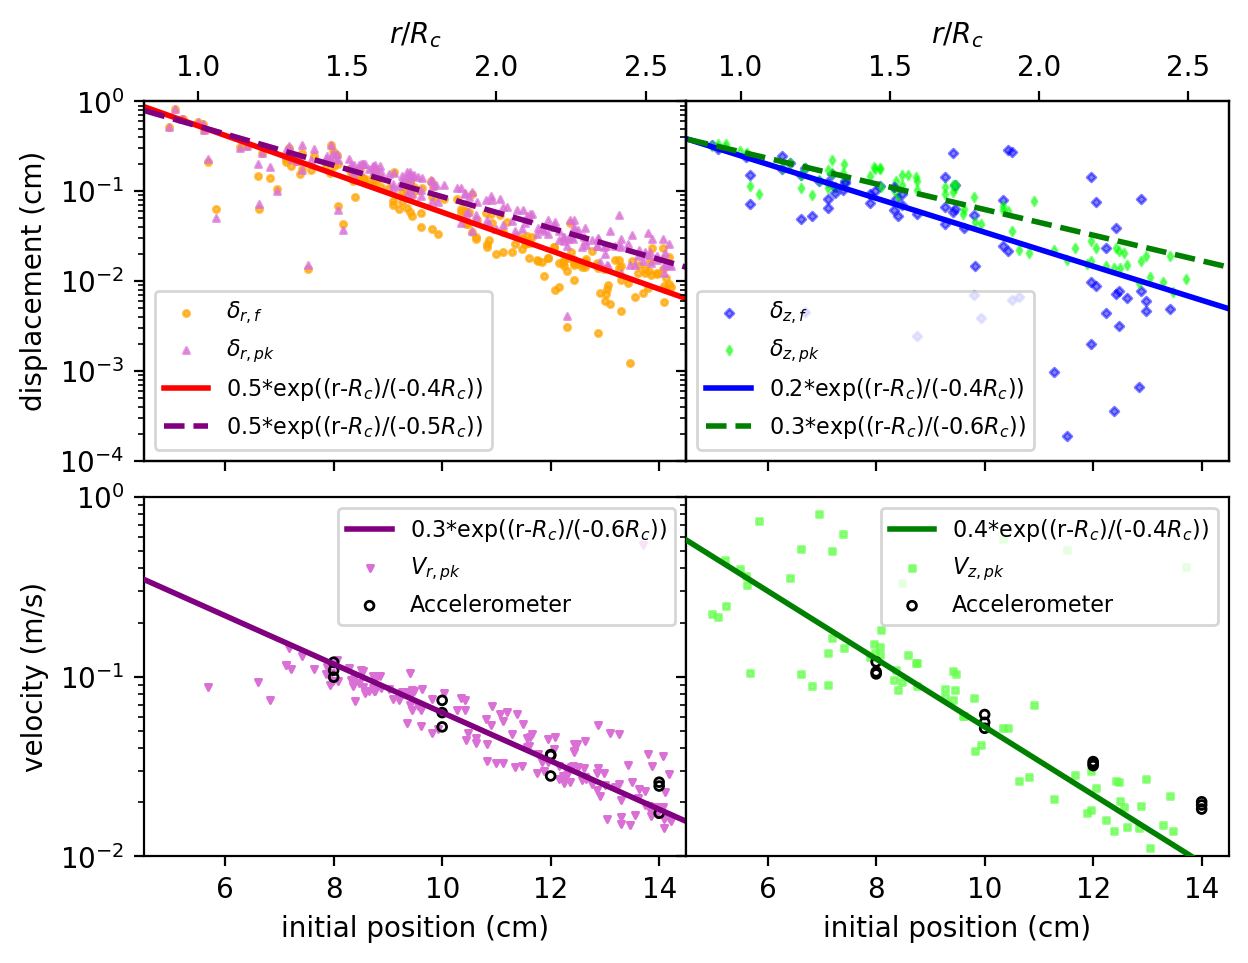

In [37]:
 fig = plt.figure(figsize=(7,5),dpi=200)
gs = fig.add_gridspec(2, 2, hspace=0.1, wspace=0)
(ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')

#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8,5), dpi=200)

for i in range(5):
    ax1.scatter(total[i,0,:],total[i,1,:], marker="o", color="orange", s=5, alpha=alpha)
ax1.scatter(total[5,0,:],total[5,1,:], marker="o",color="orange", s=5, alpha=alpha, label="$\delta_{r,f}$", zorder = 1)
#peak radial position 
for i in range(5):
    ax1.scatter(total[i,0,:],total[i,2,:], marker="^",color='orchid', s=5, alpha=alpha)
ax1.scatter(total[5,0,:],total[5,2,:], marker="^",color='orchid', s=5, label="$\delta_{r,pk}$", zorder = 2, alpha=alpha)

for i in range(2):
    ax2.scatter(totalz[i,0,:],totalz[i,1,:], marker="D", color=(0,0,1,0.5), s=5)
ax2.scatter(totalz[i,0,:],totalz[2,1,:], marker="D", color=(0,0,1,0.5), s=5, label="$\delta_{z,f}$", zorder = 3)
#peak vertical position
for i in range(2):
    ax2.scatter(totalz[i,0,:],totalz[i,2,:], marker="d", color=(0,1,0,0.5), s=5)
ax2.scatter(totalz[2,0,:],totalz[2,2,:], marker="d", color=(0,1,0,0.5), s=5, label="$\delta_{z,pk}$", zorder = 4)

#b = 1/(R_c*B) -> B = 1/(R_c*b)
ax1.plot(xs, expo((parameters[0,0],parameters[0,1]),xs), label = str(round(parameters[0,0],1)) + "*exp((r-$R_c$)/(" + str(round(parameters[0,1],1)) + "$R_c$))", zorder = 5, c = 'red', lw = 2)
ax1.plot(xs, expo((parameters[1,0],parameters[1,1]),xs), label = str(round(parameters[1,0],1)) + "*exp((r-$R_c$)/(" + str(round(parameters[1,1],1)) + "$R_c$))", zorder = 6, c = 'purple', ls = "--", lw = 2)
ax2.plot(xs, expo((parameters[2,0],parameters[2,1]),xs), label = str(round(parameters[2,0],1)) + "*exp((r-$R_c$)/(" + str(round(parameters[2,1],1)) + "$R_c$))", zorder = 7, c = 'blue', lw=2)
ax2.plot(xs, expo((parameters[3,0],parameters[3,1]),xs), label = str(round(parameters[3,0],1)) + "*exp((r-$R_c$)/(" + str(round(parameters[3,1],1)) + "$R_c$))", zorder = 8, c = 'green', ls = '--', lw = 2)
ax3.plot(xs, expo((parameters[4,0],parameters[4,1]),xs), label = str(round(parameters[4,0],1)) + "*exp((r-$R_c$)/(" + str(round(parameters[4,1],1)) + "$R_c$))", zorder = 9, c = 'purple', lw = 2)
ax4.plot(xs, expo((parameters[5,0],parameters[5,1]),xs), label = str(round(parameters[5,0],1)) + "*exp((r-$R_c$)/(" + str(round(parameters[5,1],1)) + "$R_c$))", zorder = 10, c = 'green', lw = 2)

xmin = 4.5
xmax = 14.5
ax1.set_xlim(4.5,14.5)
ax2.set_xlim(4.5,14.5)
ax1.set_yscale('log')
ax2.set_yscale('log')

handles, labels = ax1.get_legend_handles_labels()
order = [2,3,0,1]

ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

handles, labels = ax2.get_legend_handles_labels()
order = [2,3,0,1]

ax2.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
ax1.set_ylabel('displacement (cm)')
#ax1.set_xlabel('initial position in cm')
#ax2.set_ylabel('displacement in cm')
#ax2.set_xlabel('initial position in cm')
ax1.set_ylim(.0001,1)
ax2.set_ylim(.0001,1)
axi2 = ax1.twiny()
Rcr = 5.5 #crater radius in cm 
axi2.set_xlim([xmin/Rcr,xmax/Rcr]) 
axi2.set_xlabel("$r/R_c$")
axi5 = ax2.twiny()
axi5.set_xlim([xmin/Rcr,xmax/Rcr])
axi5.set_xlabel("$r/R_c$")
#ax2. yaxis. set_visible(False)

for i in range(5):
    ax3.scatter(totalv[i,0,:],totalv[i,1,:]/100,  marker="v", color='orchid', s=5)
ax3.scatter(totalv[5,0,:],totalv[5,1,:]/100,  marker="v", color='orchid', s=5, label = "$V_{r,pk}$")
    
for i in range(2):
    ax4.scatter(totalvz[i,0,:],totalvz[i,1,:]/100,  marker="s", color=(0.4,1,0.3,0.7), s=5)
ax4.scatter(totalvz[2,0,:],totalvz[2,1,:]/100,  marker="s", color=(0.4,1,0.3,0.7), s=5, label = "$V_{z,pk}$")

#for i in range(6):
    #ax1.errorbar(total[i,0,:],total[i,1,:], xerr = 0.3, yerr = 0.01, fmt="none")

xerr = 0.3   #cm
yerr = 0.02  #cm (half of a grain radius)

#pars, cov = curve_fit(f=power, xdata=tdr_initials, ydata=tdr_finals, p0=[1200, -4], bounds=(-np.inf, np.inf))#HAVE TO GET THINGS IN THE RIGHT FORM DAMMIT
#plt.plot(xs,exponential(xs, pars[0], pars[1]), linestyle='--', linewidth=2, color='black') #power(xs, 62.90126299, 0.5574180747)
#print(pars)
#print(cov)

ax3.scatter(peak_velx[:,1], peak_velx[:,2], marker = "o", s = 10, label = "Accelerometer", facecolors='none', edgecolors='k')
ax4.scatter(peak_vely[:,1], peak_vely[:,2], marker = "o", s = 10, label = "Accelerometer", facecolors='none', edgecolors='k')
    
ax3.set_xlim(4.5,14.5)
ax4.set_xlim(4.5,14.5)
ax3.set_yscale('log')
ax4.set_yscale('log')
ax3.legend()
ax4.legend()
ax3.set_ylabel('velocity (m/s)')
ax3.set_xlabel('initial position (cm)')
#ax2.set_ylabel('displacement in cm')
ax4.set_xlabel('initial position (cm)')
ax3.set_ylim(.01,1)
ax4.set_ylim(.01,1)
#ax4. yaxis. set_visible(False)
#ax1.legend(loc='lower left')


ax1.legend(labelspacing = 0.2)
ax2.legend(labelspacing = 0.2)
ax3.legend(labelspacing = 0.2)
ax4.legend(labelspacing = 0.2)

ax1.legend(prop={'size': 8})
ax2.legend(prop={'size': 8})
ax3.legend(loc='upper right', prop ={'size': 8})
ax4.legend(loc='upper right', prop ={'size': 8})


plt.show()

fig.savefig("exponential_law.png", dpi=500)
#do fits, add error bars
#do another derivative to get acceleration exponent
#do scaling stuff (divide by momentum?)
#error in initial position ~0.3 cm, error in displacement ~3.5 pixels (grain radius) which is .02 cm

In [38]:
def exp2(p,x):
    a,b = p
    return parameters[4,0]*np.exp((x-R)/(R*parameters[4,1]))
power_model = odr.Model(exp2)

def exp3(p,x):
    a,b = p
    return parameters[5,0]*np.exp((x-R)/(R*parameters[5,1]))


#radial peak velocity
data = odr.RealData(tvr_initials, tvr_peaks, sx=xerr, sy=yerr/1)
Odr = odr.ODR(data, power_model, beta0=[2000., -5.0])
out = Odr.run()
popt = out.beta
perr = out.sd_beta
print('———————————–')
print('radial peak vel fit parameter 1-sigma error')
for i in range(len(popt)):
    print(str(popt[i])+' +- '+str(perr[i]))
print(out.res_var)

#parameters1[4,:2] = popt[:]
#parameters1[4,2:4] = perr[:]

power_model = odr.Model(exp3)

#vertical peak velocity
data = odr.RealData(tvz_initials, tvz_peaks, sx=xerr, sy=yerr/0.5)
Odr = odr.ODR(data, power_model, beta0=[2000., -5.0])
out = Odr.run()
popt = out.beta
perr = out.sd_beta
print('———————————–')
print('vertical peak vel fit parameter 1-sigma error')
for i in range(len(popt)):
    print(str(popt[i])+' +- '+str(perr[i]))
print(out.res_var)  

———————————–
radial peak vel fit parameter 1-sigma error
2000.0 +- 0.0
-5.0 +- 0.0
0.69369268874249
———————————–
vertical peak vel fit parameter 1-sigma error
2000.0 +- 0.0
-5.0 +- 0.0
0.8187044476931066
